Autors: Elouan Vincent & Matthieu Lucchesi

I do not have a GPU so I'm using a CPU to train models, that's why we cannot tune a lot hyperparameters and we are restricted in the number of epochs to train our models.

In [1]:
# Import monai and ITK
import monai
import itk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from monai.apps import DecathlonDataset

# Set the directory where you want to download the dataset


from pathlib import Path
directory = Path("Data")
directory.mkdir(exist_ok=True)
task_name = "Task08_HepaticVessel"
if not directory.joinpath(task_name).exists():
    ds = DecathlonDataset(
        root_dir=str(directory),
        task=task_name,
        section="training",
        download=True,
        cache_rate=0.0,
    )
else:
    ds = DecathlonDataset(root_dir=str(directory), task=task_name, section="training", download=False, cache_rate=0.0)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [3]:
# Access an image from the dataset (change index as needed)
image_path = ds.data[0]["image"]
itk_image = itk.imread(str(image_path))

# Compute basic statistics using ITK
statistics_filter = itk.StatisticsImageFilter.New(itk_image)
statistics_filter.Update()

# Extract computed statistics
mean = statistics_filter.GetMean()
variance = statistics_filter.GetVariance()
minimum = statistics_filter.GetMinimum()
maximum = statistics_filter.GetMaximum()

# Print the computed statistics
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")


Mean: -629.4524821888317
Variance: 243278.19429330732
Minimum: -1024.0
Maximum: 1302.0


Fast marching level-set segmentation


# Visualization

In [4]:
from pathlib import Path
data_dir = Path("Data/Task08_HepaticVessel")
train_images = sorted(Path(data_dir, "imagesTr").glob("hepaticvessel*.nii.gz"))
print(len(train_images))
train_labels = sorted(Path(data_dir, "labelsTr").glob("hepaticvessel*.nii.gz"))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts = data_dicts[:-9]

303


In [5]:
import numpy as np
from monai.transforms import LoadImaged, Compose, EnsureChannelFirstd

trans = Compose([LoadImaged(keys=["image", "label"], image_only=False), EnsureChannelFirstd(keys=["image", "label"])])
data = trans(train_data_dicts[0])
print(f"image shape: {data['image'].shape}")
print(f"image affine:\n{data['image'].meta['affine']}")
print(f"image pixdim:\n{data['image'].pixdim}")

image shape: torch.Size([1, 512, 512, 49])
image affine:
tensor([[   0.9180,    0.0000,    0.0000, -469.0822],
        [   0.0000,    0.9180,    0.0000, -469.0822],
        [   0.0000,    0.0000,    5.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
image pixdim:
tensor([0.9180, 0.9180, 5.0000], dtype=torch.float64)


invalid value encountered in cast


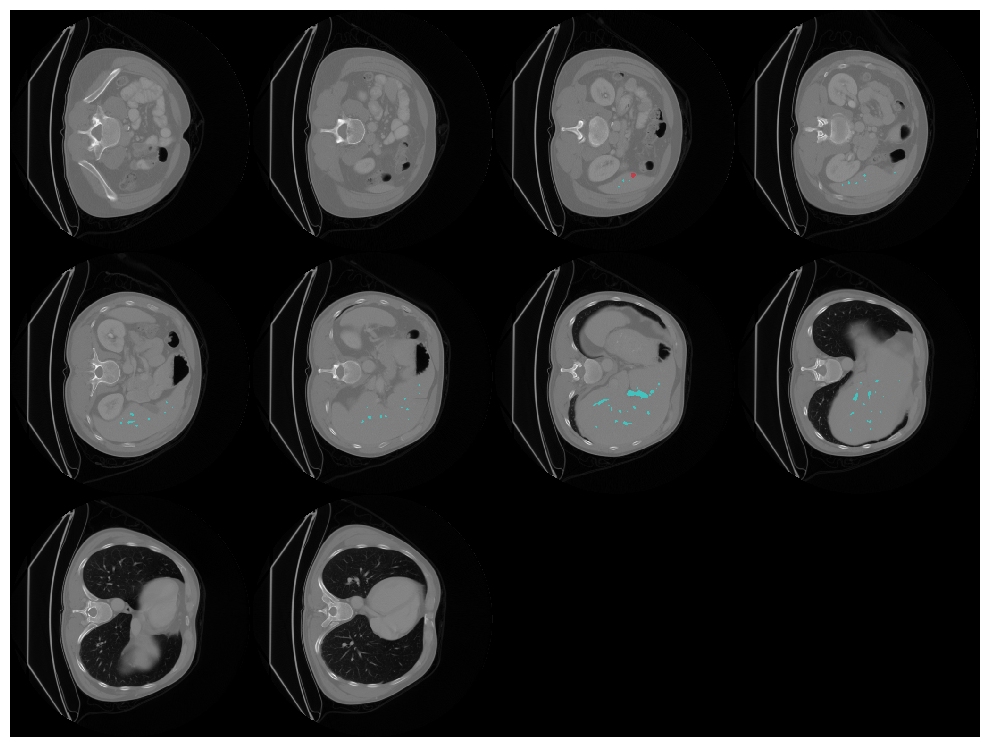

In [6]:
%matplotlib inline
from monai.visualize import matshow3d, blend_images

ret = blend_images(image=data["image"], label=data["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Preparing data

In [7]:
from pathlib import Path
data_dir = Path("Data/Task08_HepaticVessel")
train_images = sorted(Path(data_dir, "imagesTr").glob("hepaticvessel*.nii.gz"))
print(len(train_images))
train_labels = sorted(Path(data_dir, "labelsTr").glob("hepaticvessel*.nii.gz"))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

303


In [8]:
# Split the data into training and validation datasets
from monai.data import Dataset, ArrayDataset, DataLoader, CacheDataset, PersistentDataset

train_ratio = 0.8
num_train = int(train_ratio * len(data_dicts))
# Shuffle the data before splitting
np.random.seed(0)
np.random.shuffle(data_dicts)
train_data_dicts = data_dicts[:num_train]
val_data_dicts = data_dicts[num_train:]

In [9]:
# Define transforms for image and mask
from monai.transforms import (
    LoadImaged,
    AddChanneld,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ToTensord,
    ConvertToMultiChannelBasedOnBratsClassesd,
)
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, RandSpatialCropd, RandFlipd,
    NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd
)

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[112, 112, 72], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

In [10]:
cache_dir = Path("Data/Cache")

In [16]:
# Define a dataset that encapsulates our data, transforms, and metadata
train_ds = PersistentDataset(data=train_data_dicts, transform=train_transform, cache_dir=cache_dir)
val_ds = PersistentDataset(data=val_data_dicts, transform=val_transform, cache_dir=cache_dir)
print("Dataset size:", len(train_ds), len(val_ds))
# Define a dataloader that encapsulates our dataset
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

# Change these values to limit the training / validation size
max_train_size = 10 # len(train_ds)
max_val_size = 10  # len(val_ds)
train_loader = DataLoader(train_ds[:max_train_size], batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds[:max_val_size], batch_size=1, shuffle=False)

Dataset size: 242 61


In [17]:
len(train_loader), len(val_loader)

(10, 10)

torch.Size([1, 340, 340, 161])


invalid value encountered in cast


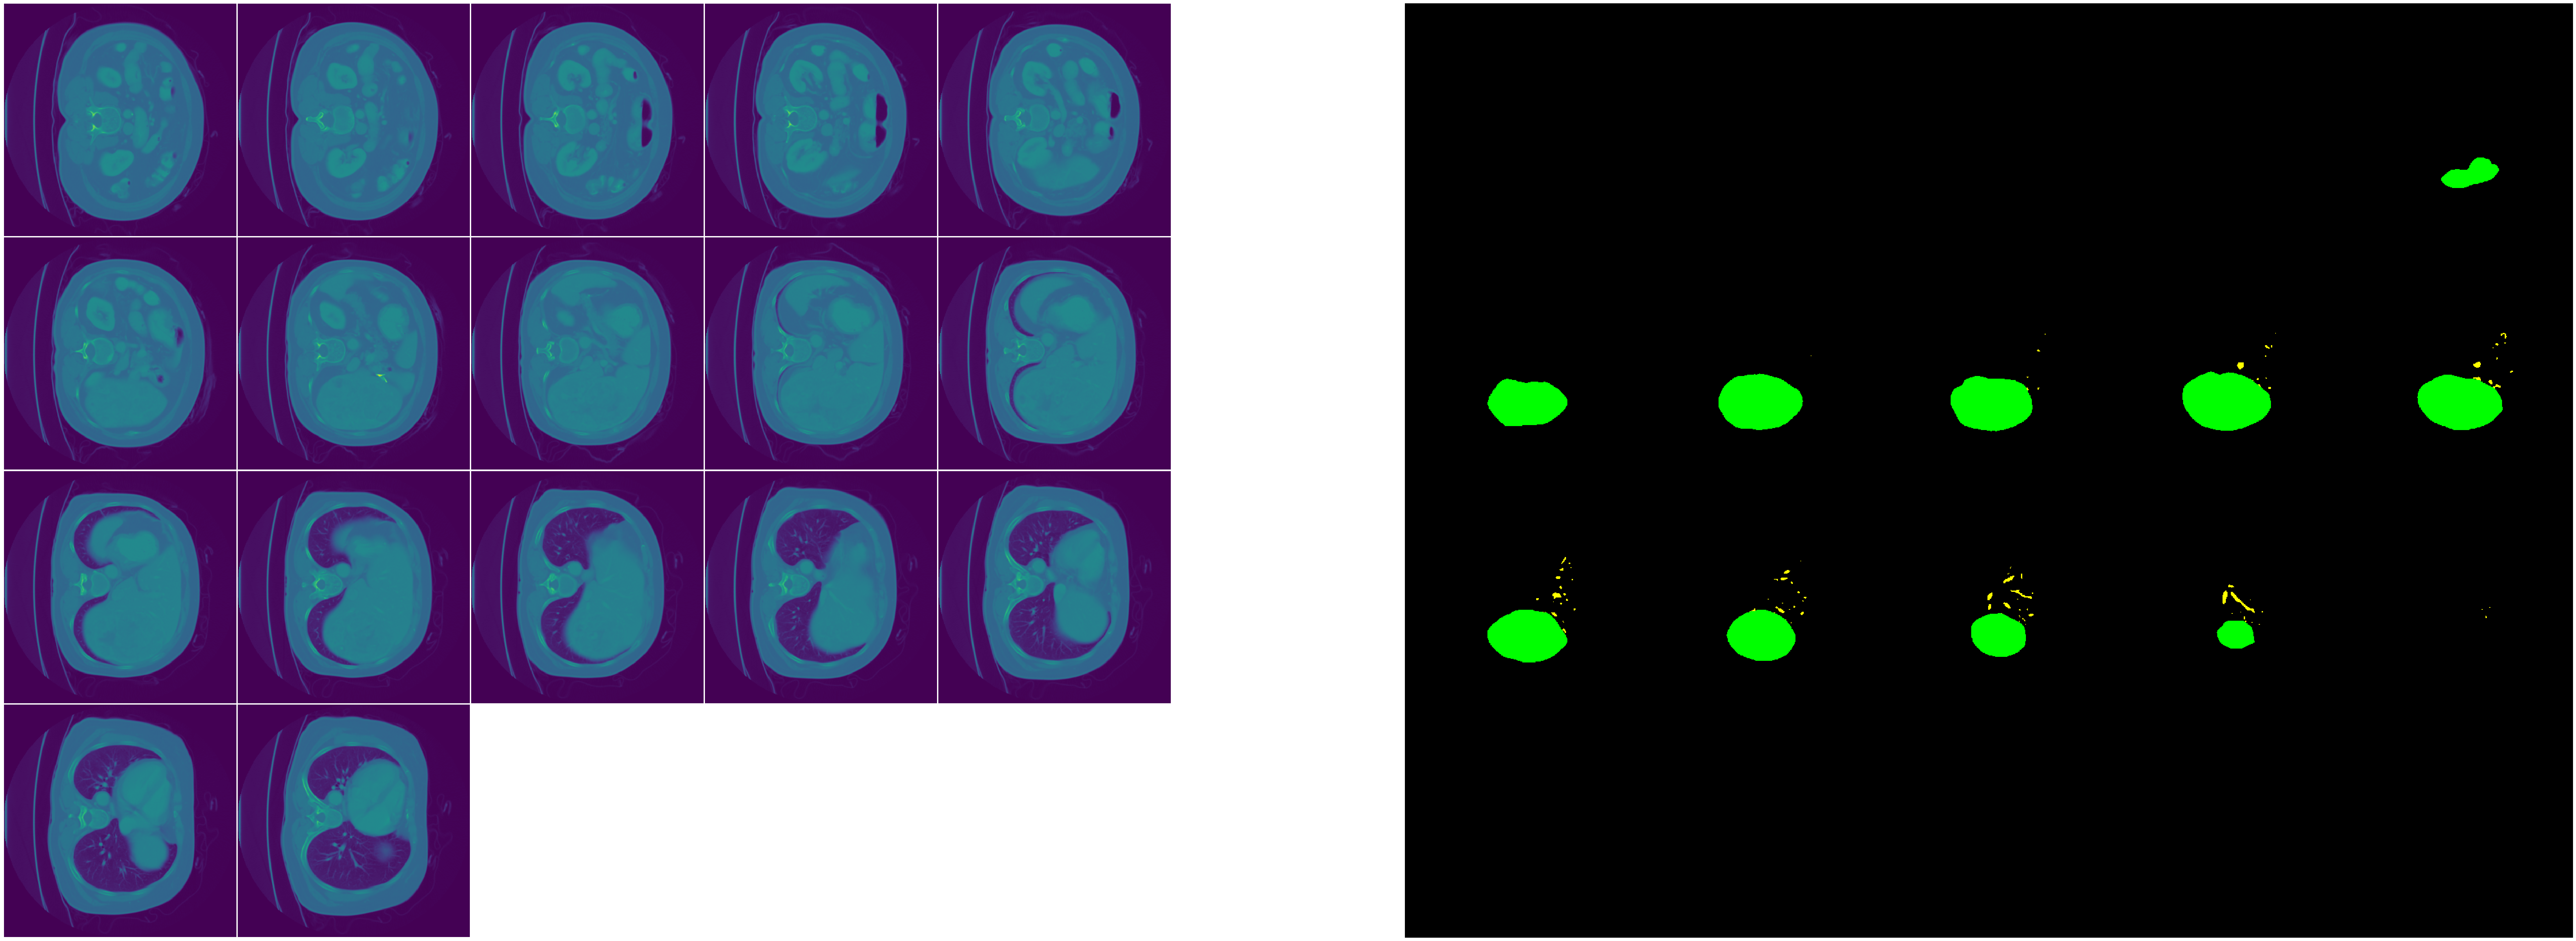

In [18]:
from matplotlib import pyplot as plt
from monai.visualize import matshow3d

val_data_example = val_ds[0]
print(val_data_example["image"].shape)

fig = plt.figure(figsize=(100, 100))
plt.subplot(1, 2, 1)
_ = matshow3d(val_data_example["image"], fig=fig.gca(), channel_dim=0, every_n=10, frame_dim=-1)
plt.subplot(1, 2, 2)
_ = matshow3d(val_data_example["label"], fig=fig.gca(), channel_dim=0, every_n=10, frame_dim=-1)


In [21]:
from monai.networks.nets import SegResNet
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.losses import DiceLoss
import torch

max_epochs = 10 # 300
val_interval = 3

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
model = SegResNet(
    init_filters=16,
    in_channels=1,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [23]:
import time
import os
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from tqdm import tqdm

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = sliding_window_inference(
                    inputs=val_inputs,
                    roi_size=(120, 120, 80),
                    sw_batch_size=1,
                    predictor=model,
                    overlap=0.5,
                )
                val_outputs = [post_trans(i)
                               for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(
                    time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(directory, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(
        f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/10


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


epoch 1 average loss: 0.9934


In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()


plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = model(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

# Inference pipeline:

In [ ]:
from monai.transforms import Invertd, SaveImaged

model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
infer_post_transform = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

evaluator = monai.engines.SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=model,
    inferer=monai.inferers.SlidingWindowInferer(
        roi_size=(128, 128, 64), sw_batch_size=4, overlap=0.5
    ),
    post_transform=infer_post_transform,
    key_val_metric={
        "val_mean_dice": monai.metrics.MeanDice(
            include_background=True, output_transform=lambda x: (x["pred"], x["label"])
        ),
        "val_mean_hd95": monai.metrics.HausdorffDistanceMetric(
            include_background=True,
            distance_metric=monai.metrics.HausdorffDistanceMetric.DISTANCE_TYPE.HD95,
            output_transform=lambda x: (x["pred"], x["label"]),
        ),
    },
)

evaluator.run()